In [40]:
import math
import torch
from torch import nn
from utils.useful_func import *
from matplotlib import pyplot as plt

In [9]:
# 先实现一个点积注意力
class DotProductAttention(nn.Module):
    def __init__(self, dropout=0.2):
        super(DotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)

    # q(b,step,embed_size)
    # k(b,键值对个数,embed_size)
    # v(b,键值对个数,embed_size)
    def forward(self, q, k, v,valid_lens):
        attn_weights = torch.bmm(q, k.transpose(1, 2))/torch.sqrt(torch.tensor(q.shape[-1]))
        self.attention_weights=masked_softmax(attn_weights,valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), v)

#@save
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    # qkv各自的embed_size, 隐藏层大小 头数量
    # 需要并行运算多个头 因此num_hiddens 必须能够整除以num_heads
    def __init__(self,key_size,query_size,value_size,num_hiddens,num_heads,dropout,bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q=nn.Linear(query_size,num_hiddens,bias=bias)
        self.W_k=nn.Linear(key_size,num_hiddens,bias=bias)
        self.W_v=nn.Linear(value_size,num_hiddens,bias=bias)
        self.W_o=nn.Linear(num_hiddens,num_hiddens,bias=bias)

    def forward(self, q, k, v,valid_lens=None):

        queries=self.W_q(q)
        keys=self.W_k(k)
        values=self.W_v(v)

        # 在这一步需要对qkv拆分为多头 并行计算attention
        queries=queries.reshape(queries.shape[0],queries.shape[1],self.num_heads,-1).permute(0,2,1,3)
        keys=keys.reshape(keys.shape[0],keys.shape[1],self.num_heads,-1).permute(0,2,1,3)
        values=values.reshape(values.shape[0],values.shape[1],self.num_heads,-1).permute(0,2,1,3)

        queries=queries.reshape(-1,queries.shape[2],queries.shape[3])
        keys=keys.reshape(-1,keys.shape[2],keys.shape[3])
        values=values.reshape(-1,values.shape[2],values.shape[3])

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        attn_weights=self.attention(queries,keys,values,valid_lens)
        attn_weights=attn_weights.reshape(-1,self.num_heads,attn_weights.shape[1],attn_weights.shape[2])
        attn_weights=attn_weights.permute(0,2,1,3)
        attn_weights=attn_weights.reshape(attn_weights.shape[0],attn_weights.shape[1],-1)

        return self.W_o(attn_weights)


In [10]:
# 自注意力
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [11]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])

In [12]:

X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

In [33]:
X=torch.arange(10,dtype=torch.float32).reshape(-1,1)/\
    torch.pow(10000,torch.arange(0,10,2)/num_hiddens)

In [34]:
X.shape

torch.Size([10, 5])

In [35]:
# 位置编码
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        # 创建一个足够长的P 长是指第2个维度 第一个维度应该是batch_size
        # 每一个batch用的是一套位置编码 如果不用一套的话就无法学习到位置信息泛化能力极差
        self.P=torch.zeros(1,max_len,num_hiddens)
        self.dropout = nn.Dropout(dropout)
        X=torch.arange(max_len,dtype=torch.float32).reshape(-1,1)/\
            torch.pow(10000,torch.arange(0,num_hiddens,2)/num_hiddens)
        self.P[:,:,0::2]=torch.sin(X)
        self.P[:,:,1::2]=torch.cos(X)
    def forward(self, X):
        X = X+self.P[:,:X.shape[1],:].to(X.device)
        return self.dropout(X)


In [36]:
X.shape

torch.Size([10, 5])

In [60]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X=torch.zeros((1, num_steps, encoding_dim))
X = pos_encoding(X)
P = pos_encoding.P[:, :X.shape[1], :]

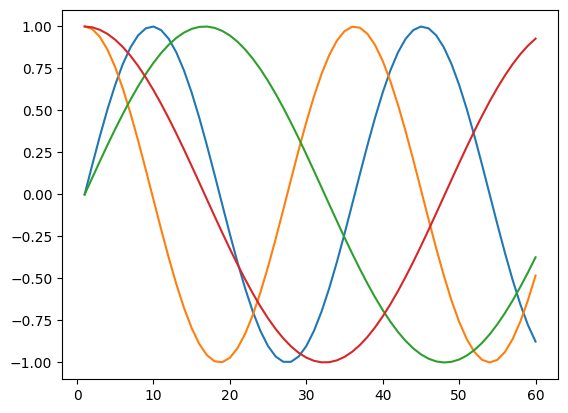

In [61]:
plt.plot(np.arange(1, num_steps+1), P[0,:,6:10])

In [62]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)


In [69]:
posit=P.squeeze()
posit.shape

torch.Size([60, 32])

In [ ]:
plt.imshow(posit,cmap='Blues')